# MNIST classification

- https://en.wikipedia.org/wiki/MNIST_database

1. Naive-Bayes Classifier
    - skip. Less interesting. Maybe later.
2. Neural Netowrk
    - mini-batch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn

print('numpy: ', np.__version__)
print('sklearn: ', sklearn.__version__)

numpy:  1.16.6
sklearn:  0.22.2.post1


## Dataset can be obtained directly from `torchvision`

In [2]:
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True)

len(mnist_train), len(mnist_test)

(60000, 10000)

### Returned are PIL Image and target label

<PIL.Image.Image image mode=L size=28x28 at 0x234D018E2C8> 5


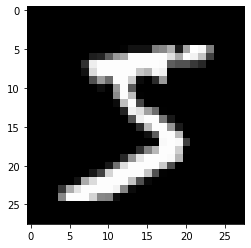

In [3]:
im, label = mnist_train[0]
plt.imshow(im, cmap='gray')
print(im, label)

### Convert to Tensor and A Custom torchvision.transformation for Binarization

In [4]:
class MyBinarization:
    """ convert a gray scale tensor [0, 1] to binary tensor of {0., 1.}"""
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def __call__(self, im):
        bright = im > self.threshold
        im[bright] = 1.
        im[~bright] = 0.
        return im

data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: (im>0.5).float()), # another way to do binarizaiton
                                     #MyBinarization() ,
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1)) # 
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

(torch.Size([784]), torch.float32, 5, array([0., 1.], dtype=float32), int, 784)

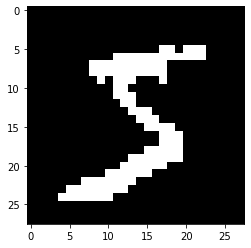

In [5]:
im, label = mnist_train[0]
plt.imshow(im.reshape(28,28), cmap='gray')
im.shape, im.dtype, label, np.unique(im), type(label), 28*28

## Tensor --> Numpy

In [6]:
def get_mnist_data(ds):
    x = np.empty((len(ds), 784))
    y = np.empty(len(ds),dtype=np.int64)
    for i in range(x.shape[0]):
        x[i,:], y[i] = ds[i]
    return x, y

In [7]:
%%time
Xtrain, ytrain = get_mnist_data(mnist_train)
Xtest,  ytest  = get_mnist_data(mnist_test)

Wall time: 6.95 s


## Bernoulli Naive Bayes
- https://github.com/dsgiitr/d2l-pytorch/blob/master/Ch04_The_Preliminaries_A_Crashcourse/Naive_Bayes_Classification.ipynb

In [8]:
xcount = torch.ones((im.reshape(-1).shape[0],10)).float()
ycount = torch.ones((10))

for im, label in mnist_train:
    xcount[:,label] += im.reshape(-1)
    ycount[label] += 1
#

In [9]:
py = ycount / ycount.sum()
px = xcount / ycount.unsqueeze(0) # each row is divided by ycount

- For example, px[300,:] shows the Bernoulli probability at the location 300 for the class labels.
- px[300,**k**] is the probability of being a bright pixel at the location 300 provided the class is **k**

In [10]:
px[300,:]

tensor([0.6437, 0.0114, 0.3167, 0.1797, 0.3377, 0.1046, 0.0781, 0.4349, 0.4508,
        0.3057])

In [11]:
py

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

Class Conditional Probabilities: 


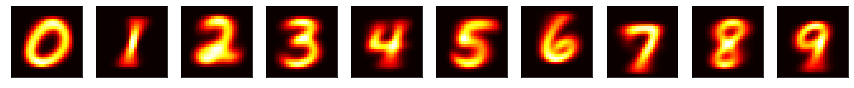

Class Prior Probabilities:
  tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])


In [12]:
fig, axes = plt.subplots(1,10, figsize=(15,10))
print('Class Conditional Probabilities: ')
for i in range(10):
    axes[i].imshow(px[:,i].reshape(28,28).numpy(), cmap='hot')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()
print('Class Prior Probabilities:\n ', py)

* Notice that the images are well aligned within classes.

In [13]:
np.unique(mnist_train.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

## Now let's make a random sample of a number.

In [14]:
def sample(n, px):
    probs = px[:,n] # Bernoulli probability for each pixel, the probability that a sample has 1 as the outcome.
    qrobs = 1 - probs # the probability that a sample has 0 as the outcome
#     print(probs.shape)
    result = torch.empty_like(probs)
    for i in range(probs.shape[0]):
        r = torch.rand(1)
        if r < qrobs[i]:
            result[i] = 0.
        else:
            result[i] = 1.
    return result

In [15]:
def plot_samples(sample_number=0, n_imgs=10, nrows=3):
    fig, axes = plt.subplots(nrows, n_imgs, figsize=(15,4))
    for i, ax in enumerate(axes.flatten()):
        if i == 0:
            ax.imshow(px[:,sample_number].reshape(28,28), cmap='gray')
        else:
            s = sample(sample_number, px)
            ax.imshow(s.numpy().reshape(28,28), cmap='gray');
        ax.set_xticks([])
        ax.set_yticks([])

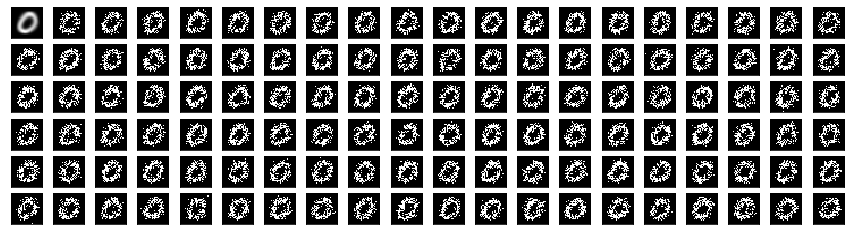

In [16]:
plot_samples(0, 20, 6)

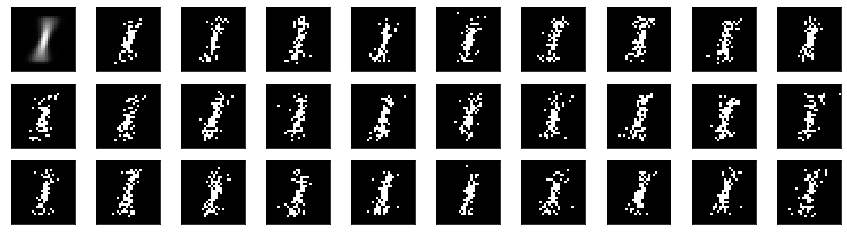

In [17]:
plot_samples(1)

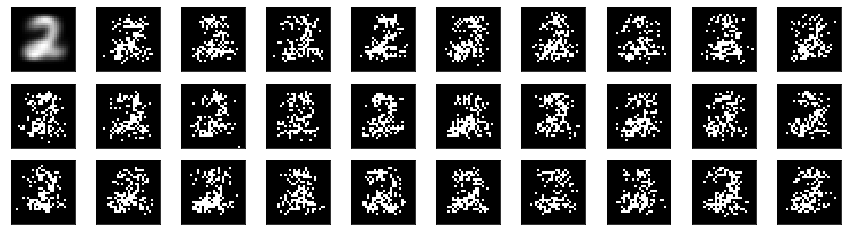

In [18]:
plot_samples(2)

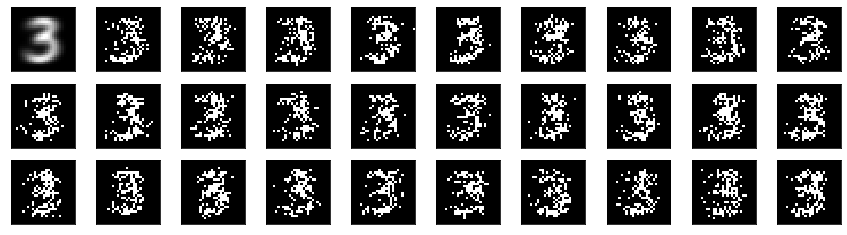

In [19]:
plot_samples(3)

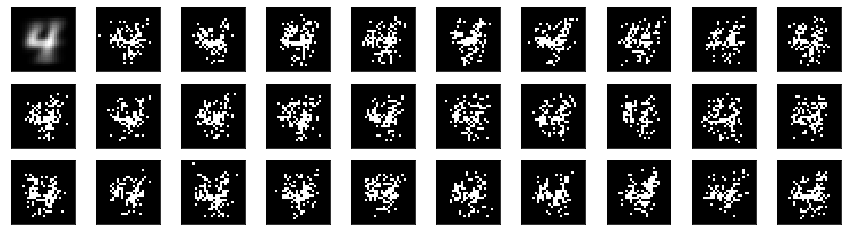

In [20]:
plot_samples(4)

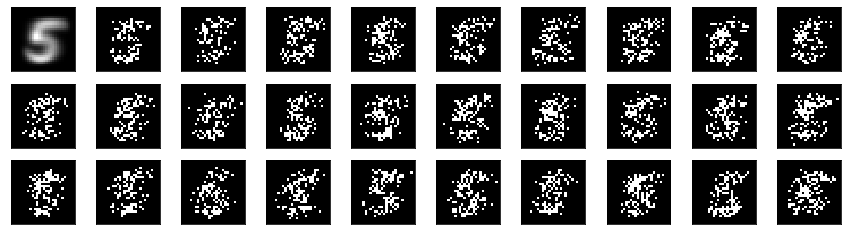

In [21]:
plot_samples(5)

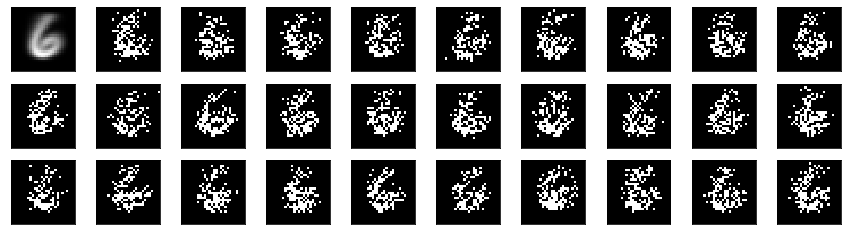

In [22]:
plot_samples(6)

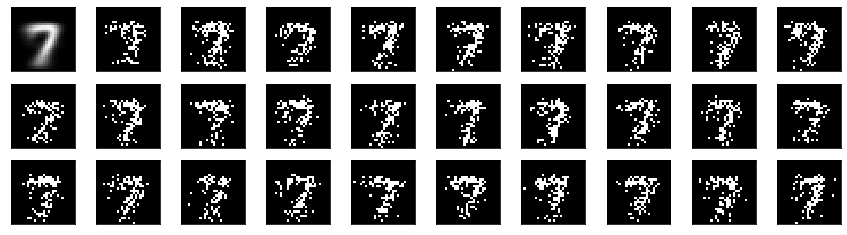

In [23]:
plot_samples(7)

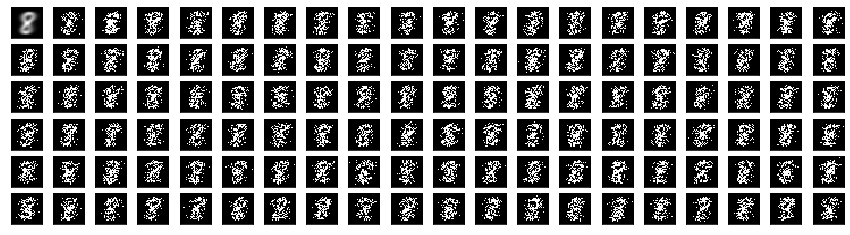

In [24]:
plot_samples(8, 20, 6)

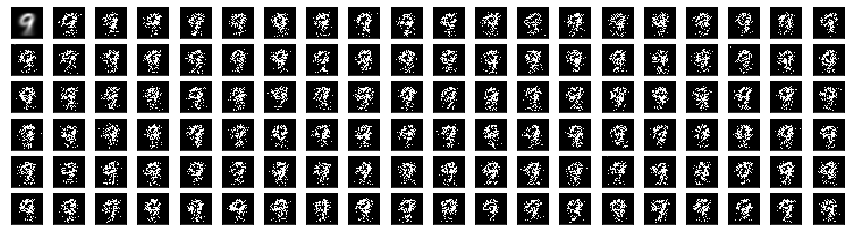

In [25]:
plot_samples(9, 20, 6)

## Summary
- Pixel-wise independent assumption leads to Bernoulli distribution.
- Probability can be easily computed.
- The samples from Bernoulli model are weird.

## Bernoulli Naive Bayes

$$
    \begin{align}
        P(Y=0|X=x) = \frac{P(x|Y=0)P(Y=0)}{\sum_k P(x|Y=k)P(Y=k)}
    \end{align}
$$

In [26]:
%%time

log_px = np.log(px.numpy())
log_qx = np.log(1-px.numpy())
log_py = np.log(py.numpy())

def log_likeli(x,y):
    m = x*log_px[:,y] + (1.-x)*log_qx[:,y]
    return m.sum()

def log_P(y):
    return log_py[y]

n_correct = 0
for tensor, label in mnist_test:
    x = tensor.numpy()
    log_posterior = np.zeros(10)
    for y in range(10):
        log_posterior[y] = log_likeli(x, y) + log_P(y)  # P(Y=y|X=x)
    #
    pred_label = np.argmax(log_posterior)
#     print(log_posterior, pred_label)
    
    if pred_label == label:
        n_correct += 1
#     break
print('accuracy: ', n_correct/len(mnist_test))

accuracy:  0.8426
Wall time: 2.01 s


In [27]:
%%time

log_px = np.log(px.numpy())
log_qx = np.log(1. - px.numpy())
log_py = np.log(py.numpy())

n_correct = 0
for tensor, label in mnist_test:
    x = tensor.numpy()
    log_posterior = np.dot(log_px.T, x) + np.dot(log_qx.T, 1. - x) + log_py
    pred_label = np.argmax(log_posterior)
    
    if pred_label == label:
         n_correct += 1
#
print('accuracy: ', n_correct/len(mnist_test))

accuracy:  0.8426
Wall time: 1.04 s


---
## sklearn 
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html?highlight=bernoullinb

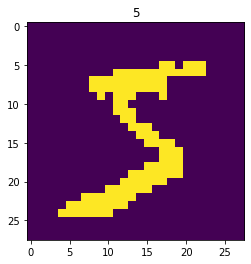

In [28]:
plt.imshow(Xtrain[0].reshape(28,28))
plt.title(f'{ytrain[0]}');

In [29]:
%%time
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(binarize=0.5)
bnb.fit(Xtrain, ytrain)
bnb.score(Xtest, ytest)

Wall time: 741 ms


0.8427

In [30]:
bnb.class_log_prior_

array([-2.31550148, -2.18598795, -2.30960971, -2.28098669, -2.32927136,
       -2.40406426, -2.31634601, -2.25936597, -2.32773198, -2.31112142])

In [31]:
log_py

array([-2.3154993, -2.1860063, -2.3096085, -2.2809904, -2.3292668,
       -2.4040465, -2.3163438, -2.259373 , -2.3277278, -2.31112  ],
      dtype=float32)

In [32]:
bnb.feature_log_prob_.shape

(10, 784)

Class Conditional log-Probabilities: 


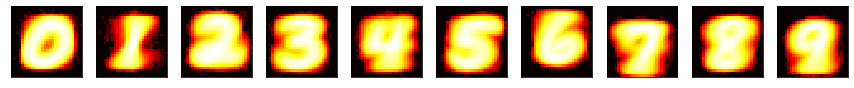

In [33]:
fig, axes = plt.subplots(1,10, figsize=(15,10))
print('Class Conditional log-Probabilities: ')
for i in range(10):
    axes[i].imshow(bnb.feature_log_prob_[i].reshape(28,28), cmap='hot')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()

Class Conditional log-Probabilities: 


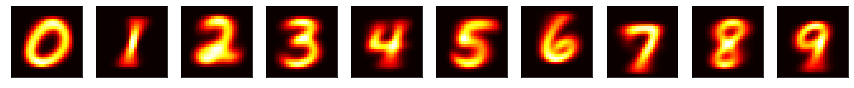

In [34]:
fig, axes = plt.subplots(1,10, figsize=(15,10))
print('Class Conditional log-Probabilities: ')
for i in range(10):
    axes[i].imshow(np.exp(bnb.feature_log_prob_[i]).reshape(28,28), cmap='hot')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()

In [35]:
pred_y = bnb.predict(Xtest)

In [36]:
(pred_y == ytest).sum()

8427

---
End.